# Respiratory Disease Classification
***
## Table of Contents
***

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import os
import warnings
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from PIL import Image

from sklearn.model_selection import train_test_split
from numpy.typing import NDArray
from torchvision import datasets, transforms, models
from torchinfo import summary
from torchmetrics import Accuracy, F1Score
from pathlib import Path
from sklearn.metrics import confusion_matrix, classification_report
from torch.utils.data import DataLoader, Subset, Dataset

In [2]:
# Set a seed for reproducibility.
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)

## 1. Introduction


## 2. Device Agnostic Code
Mac GPU acceleration (`mps` backend) delivers significant speed-up over CPU for deep learning tasks, especially for large models and batch sizes. On Windows, `cuda` is used instead of `mps`.

In [3]:
# DEVICE = torch.device(
#     device="cuda" if torch.cuda.is_available() else "cpu"
# )  # For Windows
DEVICE = torch.device(
    device="mps" if torch.backends.mps.is_available() else "cpu"
)  # For MacOS
DEVICE

device(type='mps')

## 3. Loading Data
Retrieved from [COVID-19 Radiography Database](https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database/data)

In [4]:
DATA_PATH = Path("_datasets/Radiography_Dataset")

if DATA_PATH.is_dir():
    print(f"{DATA_PATH} directory exists.")
else:
    print(f"{DATA_PATH} directory NOT FOUND!")

_datasets/Radiography_Dataset directory exists.


In [5]:
def walk_through_dir(dir_path: str) -> None:
    """
    Print the number of directories and image files in each subdirectory of a given directory.

    Args:
        dir_path: Path to the root directory to walk through.
    """

    for (
        directory_path,
        directory_names,
        file_names,
    ) in os.walk(top=dir_path):
        print(
            f"{len(directory_names)} directories and {len(file_names)} images found in {directory_path}"
        )

In [6]:
walk_through_dir(DATA_PATH)

4 directories and 1 images found in _datasets/Radiography_Dataset
2 directories and 0 images found in _datasets/Radiography_Dataset/Viral Pneumonia
0 directories and 1345 images found in _datasets/Radiography_Dataset/Viral Pneumonia/images
0 directories and 1345 images found in _datasets/Radiography_Dataset/Viral Pneumonia/masks
2 directories and 0 images found in _datasets/Radiography_Dataset/Lung_Opacity
0 directories and 6012 images found in _datasets/Radiography_Dataset/Lung_Opacity/images
0 directories and 6012 images found in _datasets/Radiography_Dataset/Lung_Opacity/masks
2 directories and 0 images found in _datasets/Radiography_Dataset/Normal
0 directories and 10192 images found in _datasets/Radiography_Dataset/Normal/images
0 directories and 10192 images found in _datasets/Radiography_Dataset/Normal/masks
2 directories and 0 images found in _datasets/Radiography_Dataset/COVID
0 directories and 3616 images found in _datasets/Radiography_Dataset/COVID/images
0 directories and 3

In [ ]:
class CustomDataset(Dataset):
    """
    Custom PyTorch Dataset for image classification from a folder structure.

    Attributes:
        img_folder: Glob pattern for image files.
        transform: Transformations to apply to images.
        extensions: Allowed image file extensions.
        all_paths: List of all image file paths.
        all_labels: List of all image class labels.
        categories: Sorted set of unique class labels.
        label2id: Mapping from class label to integer index.
        id2label: Mapping from integer index to class label.
        encoded_labels: List of class label indices for all images.
    """

    img_folder: str
    transform: transforms.Compose | None
    extensions: set[str]
    all_paths: list[Path]
    all_labels: list[str]
    categories = set[str]
    label2id = dict[str, int]
    id2label = dict[int, str]
    all_labels_indices = list[int]

    def __init__(
        self, img_path, transform=None, extensions={".png", ".jpg", ".jpeg"}
    ) -> None:
        """
        Initialise the dataset and maps image files to class indices.

        Args:
            img_path: Root directory containing image folders.
            transform: Transformations to apply on image load; optional.
            extensions: Allowed image file extensions.
        """
        img_folder = "*/images/*"
        self.img_path = img_path
        self.transform = transform
        self.all_paths = [
            path
            for path in img_path.glob(img_folder)
            if path.suffix.lower() in extensions
        ]
        # Extract labels from 2 levels above the image file
        self.all_labels = [path.parent.parent.name for path in self.all_paths]
        self.categories = sorted(set(self.all_labels))  # Unique labels
        self.label2id = {label: index for index, label in enumerate(self.categories)}
        self.id2label = {index: label for label, index in self.label2id.items()}
        self.encoded_labels = [self.label2id[label] for label in self.all_labels]

    def __len__(self) -> int:
        """
        Return the number of samples in the dataset.

        Returns:
            Number of images in the dataset.
        """
        return len(self.all_paths)

    def __getitem__(self, index) -> tuple:
        """
        Retrieve an image and its label index by dataset position.

        Args:
            index: Index of the image sample.

        Returns:
            tuple (img, label_index) where img is a tensor (if transformed) and label_index is the integer class index.
        """
        single_file_path = self.all_paths[index]
        try:
            img = Image.open(fp=single_file_path).convert("RGB")
        except Exception as e:
            raise RuntimeError(f"Error opening image {single_file_path}: {e}")
        label_index = self.encoded_labels[index]

        if self.transform:
            img = self.transform(img)
        return img, label_index


In [8]:
dataset = CustomDataset(img_path=DATA_PATH)

## 4. Understanding Data

In [9]:
def show_random_images(dataset: Dataset) -> None:
    """
    Display a grid of images from a dataset with their corresponding class names as titles.

    Args:
        dataset: Dataset (image, label). Images assumed to be tensors.
        class_names: List of class names indexed by label.
        num_images: Number of images to display. Defaults to 9.

    Prints:
        A matplotlib plot grid of images with titles.
    """
    cols, rows = 3, 3
    figure = plt.figure(figsize=(rows * 3, cols * 3))
    for i in range(1, cols * rows + 1):
        sample_index = random.randint(a=0, b=len(dataset))
        img, label = dataset[sample_index]
        figure.add_subplot(rows, cols, i)
        plt.title(dataset.id2label[label])
        plt.axis("off")
        plt.tight_layout()
        plt.imshow(img)
    plt.show()

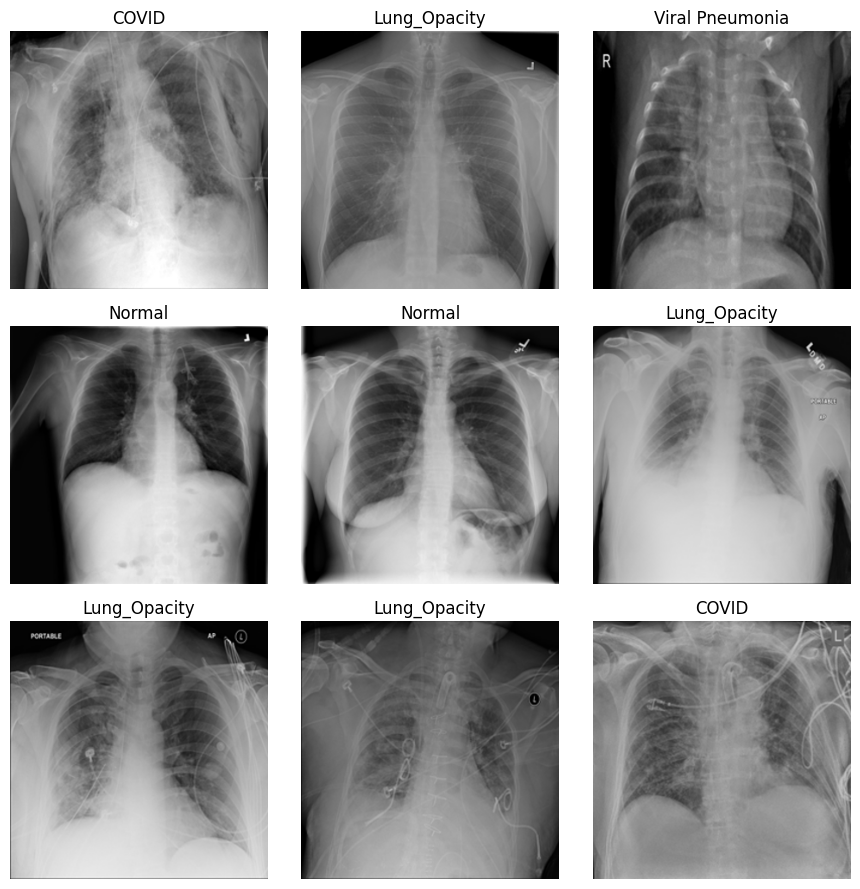

In [10]:
show_random_images(dataset)

In [11]:
dataset.id2label

{0: 'COVID', 1: 'Lung_Opacity', 2: 'Normal', 3: 'Viral Pneumonia'}

In [12]:
unique_vals, counts = np.unique(dataset.all_labels, return_counts=True)
df_dist = pd.DataFrame({"Class Label": unique_vals, "Count": counts})
print(df_dist)

       Class Label  Count
0            COVID   3616
1     Lung_Opacity   6012
2           Normal  10192
3  Viral Pneumonia   1345


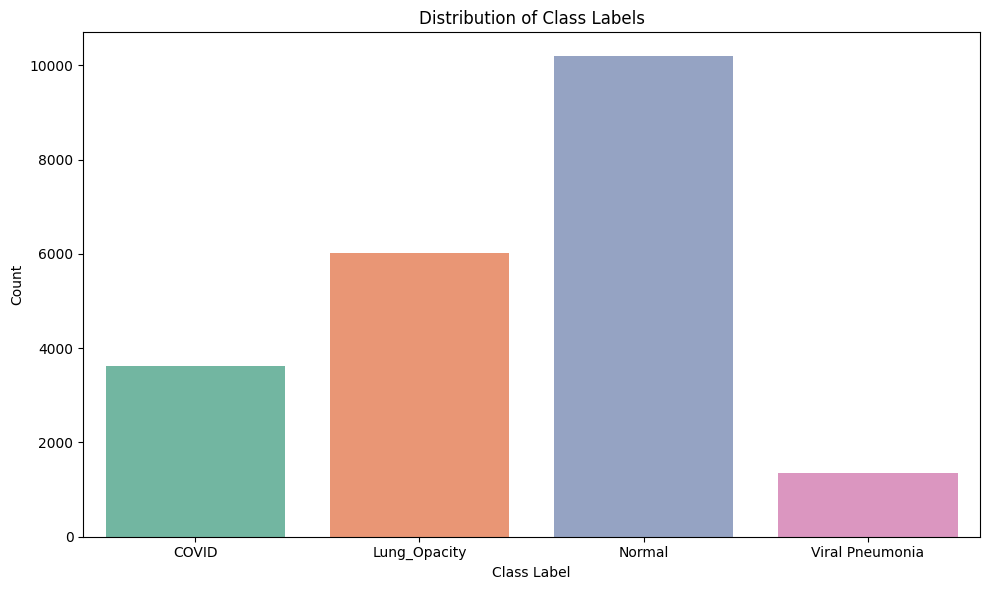

In [13]:
def plot_distribution(dataset: Dataset) -> None:
    """
    Plot the distribution of class labels in a dataset.

    Args:
        dataset: A CustomDataset or similar Dataset object with an `all_labels` attribute
                 containing the class label for each image.
    """
    unique_vals, counts = np.unique(dataset.all_labels, return_counts=True)
    df_dist = pd.DataFrame({"Class Label": unique_vals, "Count": counts})
    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=df_dist, x="Class Label", y="Count", hue="Class Label", palette="Set2"
    )
    plt.xlabel("Class Label")
    plt.ylabel("Count")
    plt.title("Distribution of Class Labels")
    plt.tight_layout()
    plt.show()


plot_distribution(dataset)

## 5. Preparing Data
### Splitting Dataset

In [14]:
def split_dataset(dataset: Dataset, random_seed: int) -> tuple[Subset, Subset, Subset]:
    """
    Split a dataset into training, validation, and test subsets using stratified sampling.

    Args:
        dataset: The full dataset to split, with an `encoded_labels` property.
        random_seed: Random seed for reproducibility of splits.

    Returns:
        The train, validation, and test dataset subsets.
    """
    all_indices = range(len(dataset))
    all_labels = dataset.encoded_labels

    train_indices, sub_indices = train_test_split(
        all_indices, test_size=0.2, stratify=all_labels, random_state=random_seed
    )  # 80% train, 20% sub

    val_indices, test_indices = train_test_split(
        sub_indices,
        test_size=0.5,
        stratify=[all_labels[i] for i in sub_indices],
        random_state=random_seed,
    )  # sub -> 50% validation, 50% test

    train_data = Subset(dataset=dataset, indices=train_indices)
    val_data = Subset(dataset=dataset, indices=val_indices)
    test_data = Subset(dataset=dataset, indices=test_indices)
    return train_data, val_data, test_data

### Data Transformation
For transfer learning using pretrained models in PyTorch, it is a common and effective practice to normalise the dataset using the standard mean and standard deviation values of the ImageNet dataset, on which many pretrained models were originally trained. This ensures that the input data distribution matches the distribution expected by the pretrained model, leading to better convergence and improved performance during fine-tuning.

[Reference - PyTorch Forums](https://discuss.pytorch.org/t/discussion-why-normalise-according-to-imagenet-mean-and-std-dev-for-transfer-learning/115670)

In addition to normalisation, various data augmentation techniques (such as random flips and random rotations) are applied to increase data diversity and improve the model's generalisation capability.

In [ ]:
BATCH_SIZE = 32
IMG_SIZE = 224
RANDOM_SEED = 42
IMAGE_NET_MEANS = [0.485, 0.456, 0.406]
IMAGE_NET_STDS = [0.229, 0.224, 0.225]
CLASS_NAMES = list(dataset.label2id.keys())
N_CLASSES = len(CLASS_NAMES)

train_transform = transforms.Compose(
    transforms=[
        transforms.Resize(size=(IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.RandomRotation(degrees=10),
        transforms.ToTensor(),
        transforms.Normalize(mean=IMAGE_NET_MEANS, std=IMAGE_NET_STDS),
    ]
)

test_transform = transforms.Compose(
    transforms=[
        transforms.Resize(size=(IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=IMAGE_NET_MEANS, std=IMAGE_NET_STDS),
    ]
)

### Preparing DataLoaders

In [16]:
train_dataset, val_dataset, test_dataset = split_dataset(dataset, RANDOM_SEED)
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = test_transform
test_dataset.dataset.transform = test_transform


train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [17]:
print(f"Batch size: {BATCH_SIZE}")
print(f"train_dataset: {len(train_dataset)} -> train_loader: {len(train_loader)}")
print(f"val_dataset: {len(val_dataset)} -> val_loader: {len(val_loader)}")
print(f"test_dataset: {len(test_dataset)} -> test_loader: {len(test_loader)}")

Batch size: 32
train_dataset: 16932 -> train_loader: 530
val_dataset: 2116 -> val_loader: 67
test_dataset: 2117 -> test_loader: 67


## 6. Transfer Learning
Transfer learning is a powerful technique in deep learning where a model pretrained on a large, general dataset is adapted for a related task. This practice improves performance while reducing the amount of training data and training time required.

Setting `param.requires_grad = False` in PyTorch freezes the model parameters (weights and biases), preventing gradient computations and updates during training. This allows parts of the model to remain unchanged while selectively training other layers.

### ResNet-50
ResNet-50 is a convolutional neural network renowned for its use of residual connections. These residual connections work as shortcut paths that enable the training of very deep networks by mitigating the vanishing gradient problem. The "50" layers refer to the number of weighted layers, constructed from a combination of convolutional layers and identity shortcuts.

The architecture is organised into four main sequential layers or blocks (layer1 to layer4), each consisting of multiple bottleneck residual blocks—typically more than two residual blocks per layer (for example, layer1 has 3 blocks, layer2 has 4, layer3 has 6, and layer4 has 3 blocks).

In our setup, freezing all layers except the final block (layer4) and the fully connected (fc) layer enables the model to retain general low- and mid-level features learned during pretraining while fine-tuning the deeper, more task-specific features. This strikes a balance between preserving learned knowledge and allowing model adaptation to new data.

In [18]:
class ResNet50(nn.Module):
    """
    ResNet-50 model adapted for classification with optional layer freezing.

    Attributes:
        device: The device to which the model is moved.
        model: The ResNet-50 backbone model.
    """

    def __init__(
        self,
        num_classes: int,
        is_frozen: bool | None = True,
        device: torch.device | str = "cpu",
    ) -> None:
        """
        Initialise ResNet-50 model with transfer learning layers.

        Args:
            num_classes: Number of output classes.
            freeze: Whether to freeze early layers. Defaults to True.
            device: Device for the model (e.g., 'cpu', 'mps' or 'cuda'). Defaults to 'cpu'.
        """
        super().__init__()
        self.device = device
        self.model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        self.model.fc = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(in_features=self.model.fc.in_features, out_features=num_classes),
        )

        if is_frozen:
            # Freeze all layers initially
            for param in self.model.parameters():
                param.requires_grad = False
            for param in self.model.layer4.parameters():
                param.requires_grad = True
            for param in self.model.fc.parameters():
                param.requires_grad = True

        self.to(device=device)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the ResNet-50 model.

        Args:
            x: Input tensor of shape (batch_size, channels, height, width).

        Returns:
            Output logits tensor of shape (batch_size, num_classes).
        """
        return self.model(x)

### DenseNet-121
DenseNet-121 is a convolutional neural network architecture characterised by dense connectivity, where each layer receives inputs from all preceding layers and passes its own feature maps to all subsequent layers. This design facilitates feature reuse, alleviates the vanishing gradient problem, and improves parameter efficiency compared to traditional convolutional networks. The network is made up of four dense blocks, each containing several densely connected convolutional layers, separated by transition layers that reduce the dimensions via convolution and pooling.

In our setup, we freeze most of the model's parameters to retain the pretrained feature representations and only unfreeze the last dense block and the classification head. This allows the model to adapt higher-level features more specifically to the new image data while preserving general, pretrained low-level features.

In [19]:
class DenseNet121(nn.Module):
    """
    DenseNet-121 model adapted for classification with optional layer freezing.

    Attributes:
        device: The device to which the model is moved.
        model: The DenseNet-121 backbone model.
    """

    def __init__(
        self,
        num_classes: int,
        is_frozen: bool | None = True,
        device: torch.device | None = "cpu",
    ) -> None:
        """
        Initialise DenseNet-121 model with transfer learning layers.

        Args:
            num_classes: Number of output classes.
            freeze: Whether to freeze early layers. Defaults to True.
            device: Device for the model (e.g., 'cpu', 'mps' or 'cuda'). Defaults to 'cpu'.
        """
        super().__init__()
        self.device = device
        self.model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
        n_features = self.model.classifier.in_features
        self.model.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(in_features=n_features, out_features=num_classes),
        )

        if is_frozen:
            for param in self.model.parameters():  # all layers
                param.requires_grad = False
            # Unfreeze only the last dense block, final batch norm and classifier by default
            for param in self.model.features[10].parameters():  # denseblock4
                param.requires_grad = True
            for param in self.model.features[11].parameters():  # norm5
                param.requires_grad = True
            for param in self.model.classifier.parameters():  # classifier
                param.requires_grad = True

        self.to(device=device)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the DenseNet-121 model.

        Args:
            x: Input tensor of shape (batch_size, channels, height, width).

        Returns:
            Output logits tensor of shape (batch_size, num_classes).
        """
        return self.model(x)


In [20]:
resnet50 = ResNet50(num_classes=N_CLASSES, device=DEVICE)
densenet121 = DenseNet121(num_classes=N_CLASSES, device=DEVICE)

In [21]:
for model in [resnet50, densenet121]:
    print(
        summary(
            model=model,
            input_size=(
                BATCH_SIZE,
                3,
                IMG_SIZE,
                IMG_SIZE,
            ),
            verbose=0,
            col_names=["input_size", "output_size", "num_params", "trainable"],
            col_width=20,
            row_settings=["var_names"],
        ),
    )
    print("\n")

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
ResNet50 (ResNet50)                           [32, 3, 224, 224]    [32, 4]              --                   Partial
├─ResNet (model)                              [32, 3, 224, 224]    [32, 4]              --                   Partial
│    └─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   (9,408)              False
│    └─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
│    └─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
│    └─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
│    └─Sequential (layer1)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    │    └─Bottleneck (0)                    [32, 64, 56, 56]     [32, 256, 5

## 7. Evaluation Metrics
We will use the following evaluation metrics:
- `torchmetrics.Accuracy`
- `torchmetrics.F1Score`
    - Macro F1 score is recommended for imbalanced datasets to evaluate performance equally across all classes. Each class's F1 contributes equally regardless of sample size.

    - Micro F1 score aggregates all true positives, false positives, and false negatives globally, thus it favours the majority classes and is close to overall accuracy.

In [ ]:
accuracy = Accuracy(task="multiclass", num_classes=N_CLASSES).to(device=DEVICE)
f1 = F1Score(task="multiclass", num_classes=N_CLASSES, average="macro").to(
    device=DEVICE
)

metrics = [accuracy, f1]

## 8. Loss Function
### Cross-Entropy Loss
Cross-Entropy Loss is a loss function used for classification problems, particularly when the model outputs probabilities using a softmax activation in the final layer. It measures the difference between the true labels and the predicted probability distribution.

For a single data point, the cross-entropy loss is defined as:

\begin{align*}
    L = - \sum^{k}_{i=1}y_{i}\log{(\hat y_{i})}
\end{align*}

where:
- $y_i$: True label for the $i$-th class. If one-hot encoded, $y_{i} = 1$ for the corrected class, $y_{i} = 0$ otherwise.
- $\hat y_i$: Predicted probability for the $i$-th class.
- $k$: Number of classes.

For a batch of $m$ data point:

\begin{align*}
    C = \dfrac{1}{m} \sum^{m}_{j=1} \left (- \sum^{k}_{i=1}y_{j, i}\log{(\hat y_{j, i})} \right)
\end{align*}

where:
- $C$: Average cross-entropy loss over the batch.
- $m$: Number of training examples (batch size).
- $k$: Number of classes.
- $y_{j, i} \in { 0, 1}$: Indicator that true class for sample $j$ corresponds to class $i$.
- $\hat y_{j, i} \in { 0, 1}$: Predicted probability for sample $j$ belonging to class $i$.

In PyTorch:
- Use `nn.CrossEntropyLoss()` directly with raw logits.
- Do not apply `Softmax()` or `LogSoftmax()` manually before the loss.
- Internally, `nn.CrossEntropyLoss() = LogSoftmax() + NegativeLogLikelihoodLoss()`. 

In [23]:
# Inversed frequency weights
class_weights = 1.0 / torch.tensor(counts, dtype=torch.float)
class_weights = (class_weights / class_weights.sum()).to(DEVICE)  # Normalised
for val, weight in zip(unique_vals, class_weights):
    print(f"Weight for {val}: {weight:.5f}")

criterion = nn.CrossEntropyLoss(weight=class_weights)

Weight for COVID: 0.21530
Weight for Lung_Opacity: 0.12949
Weight for Normal: 0.07639
Weight for Viral Pneumonia: 0.57882


## 9. Optimiser
An optimiser in neural networks is used to adjust the parameters (weights and biases) of a model during training to minimise the loss. Optimisers are essential for enabling neural networks to learn from data: without them, the model would not improve over time.

**AdamW** (a variant of the Adam optimiser) separates weight decay (L2 regularisation) from the gradient updates. This decoupling often improves a model's generalisation performance compared to the original Adam optimiser, reducing the risk of overfitting, especially in large-scale models.

**ReduceLROnPlateau** is a learning rate scheduler that monitors a specified metric (usually validation loss) and reduces the learning rate by a given factor if the metric stops improving for a certain number of epochs (`patience`). This allows the optimiser to take smaller, more precise steps when progress plateaus, often leading to better final model performance.

In [24]:
LEARNING_RATE = 1e-3
DECAY_RATE = 1e-4

# ! === ResNet-50 ===
resnet50_optimiser = optim.AdamW(
    params=filter(lambda p: p.requires_grad, resnet50.parameters()),
    lr=LEARNING_RATE,
    weight_decay=DECAY_RATE,
)
resnet50_scheduler = ReduceLROnPlateau(
    optimizer=resnet50_optimiser,
    mode="min",
    patience=3,
    factor=0.5,
)

# ! === DenseNet-121 ===
densenet121_optimiser = optim.AdamW(
    params=filter(lambda p: p.requires_grad, densenet121.parameters()),
    lr=LEARNING_RATE,
    weight_decay=DECAY_RATE,
)
densenet121_scheduler = ReduceLROnPlateau(
    optimizer=densenet121_optimiser,
    mode="min",
    patience=3,
    factor=0.5,
)

## 10. Training and Evaluation
1. Iterate through epochs
1. For each epoch, iterate through training batches, perform training steps, calculate the train loss and evaluation metrics per batch.
1. For each epoch, iterate through validation batches, perform validation steps, calculate the validation loss and evaluation metrics per batch.


### Training Steps
1. Zero the gradients
    - Clear the gradients from the previous iteration to prevent accumulation across batches.
1. Forward pass
    - Pass inputs through the model to obtain predictions.
1. Calculate loss and evaluation metrics per batch
    - Measure how far the predictions deviate from the true labels using a loss function.
    - Compute evaluation metrics (e.g., accuracy, F1 Score) for the current batch.
1. Backward pass
    - Compute gradients of the loss with respect to the model's parameters via backpropagation.
    - Update the parameter $\theta$ using the computed gradients, typically following:
    
    $$
        \theta \leftarrow \theta - \eta \dfrac{\partial \mathcal{L}}{\partial \theta}
    $$
    where $\eta$ is the learning rate.
1. Average training loss and evaluation metrics
    - Calculate the mean loss and metric values across all batches in the epoch.


## 10. Training and Evaluation
1. Iterate through epochs
1. For each epoch, iterate through training batches, perform training steps, calculate the train loss and evaluation metrics per batch.
1. For each epoch, iterate through validation batches, perform validation steps, calculate the validation loss and evaluation metrics per batch.


### Training Steps
1. Zero the gradients
    - Clear the gradients from the previous iteration to prevent accumulation across batches.
1. Forward pass
    - Pass inputs through the model to obtain predictions.
1. Calculate loss and evaluation metrics per batch
    - Measure how far the predictions deviate from the true labels using a loss function.
    - Compute evaluation metrics (e.g., accuracy, F1 Score) for the current batch.
1. Backward pass
    - Compute gradients of the loss with respect to the model's parameters via backpropagation.
    - Update the parameter $\theta$ using the computed gradients, typically following:
    
    $$
        \theta \leftarrow \theta - \eta \dfrac{\partial \mathcal{L}}{\partial \theta}
    $$
    where $\eta$ is the learning rate.
1. Average training loss and evaluation metrics
    - Calculate the mean loss and metric values across all batches in the epoch.


In [25]:
def train_step(
    model: nn.Module,
    data_loader: DataLoader,
    criterion: nn.Module,
    optimiser: optim.Optimizer,
    metrics: list[nn.Module],
    device: torch.device,
) -> tuple[float, list[float]]:
    model.train()
    for metric in metrics:
        metric.reset()
    n_total_samples = len(data_loader.dataset)
    train_loss = 0.0

    for inputs, labels in data_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        batch_size = inputs.size(0)

        # Optimiser zero grad without intervening forward pass
        optimiser.zero_grad()

        # Forward pass
        y_logits = model(inputs)

        # Calculate loss
        loss = criterion(y_logits, labels)
        train_loss += loss.item() * batch_size

        # Calculate metrics
        y_probs = torch.softmax(input=y_logits, dim=1)
        y_preds = torch.argmax(input=y_probs, dim=1)

        for metric in metrics:
            metric.update(y_preds, labels)

        # Loss backward for backpropagation (computing gradients)
        loss.backward()

        # Optimiser step to apply gradients and update parameters
        optimiser.step()

    avg_train_loss = train_loss / n_total_samples
    train_metric_scores = [metric.compute().item() * 100 for metric in metrics]
    return avg_train_loss, train_metric_scores

### Validation Steps
1. Forward pass
    - Set the model to evaluation mode (which disables dropout and batch normalisation and desactivates gradient tracking for safety).
    - Pass inputs through the model to obtain predictions.
1. Calculate loss and evaluation metrics per batch
    - Measure how far the predictions deviate from the true labels using a loss function.
    - Compute evaluation metrics (e.g., accuracy, F1-Score) for the current batch.
1. Average test loss and evaluation metrics
    - Calculate the mean loss and metric values across all batches in the epoch.

In [26]:
def validation_step(
    model: nn.Module,
    data_loader: DataLoader,
    criterion: nn.Module,
    metrics: list[nn.Module],
    device: torch.device,
) -> tuple[float, list[float]]:
    model.eval()
    val_loss = 0.0
    n_total_samples = len(data_loader.dataset)
    for metric in metrics:
        metric.reset()

    with torch.inference_mode():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            batch_size = inputs.size(0)

            # 1. Forward pass
            y_logits = model(inputs)

            # 2. Calculate loss
            loss = criterion(y_logits, labels)
            val_loss += loss.item() * batch_size

            # 3. Calculate metrics
            y_probs = torch.softmax(input=y_logits, dim=1)
            y_preds = torch.argmax(input=y_probs, dim=1)

            for metric in metrics:
                metric.update(y_preds, labels)

    avg_val_loss = val_loss / n_total_samples
    val_metric_scores = [metric.compute().item() * 100 for metric in metrics]
    return avg_val_loss, val_metric_scores

### Model Training and Evaluation Pipeline

In [27]:
def train_and_validate(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    criterion: nn.Module,
    optimiser: optim.Optimizer,
    scheduler: optim.lr_scheduler,
    metrics: list[nn.Module],
    device: torch.device,
    total_epochs: int,
) -> dict[str, list[float]]:
    model.to(device=device)
    epochs_range = range(1, total_epochs + 1)
    best_loss = float("inf")
    patience_counter = 0
    best_epoch = 0
    model_name = model.__class__.__name__.lower()

    history = {
        "train_loss": [],
        "train_acc": [],
        "train_f1": [],
        "val_loss": [],
        "val_acc": [],
        "val_f1": [],
    }

    start_time = time.time()

    for epoch in epochs_range:
        train_loss, train_metrics = train_step(
            model=model,
            data_loader=train_loader,
            criterion=criterion,
            optimiser=optimiser,
            metrics=metrics,
            device=device,
        )
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_metrics[0])
        history["train_f1"].append(train_metrics[1])

        val_loss, val_metrics = validation_step(
            model=model,
            data_loader=val_loader,
            criterion=criterion,
            metrics=metrics,
            device=device,
        )
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_metrics[0])
        history["val_f1"].append(val_metrics[1])

        scheduler.step(val_loss)  # Update learning rate based on validation loss

        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(obj=model.state_dict(), f=f"{model_name}_best.pth")
            patience_counter = 0
            best_epoch = epoch
        else:  # Early Stopping
            patience_counter += 1
            if patience_counter >= 5:
                print(f"Early stopping at epoch {epoch}")
                break
        print(f"Epoch [{epoch}/{total_epochs}]\n{'=' * 60}")
        print(
            f"{'Train Loss:':<12}{train_loss:>6.4f} | {'Train Accuracy:':<15}{train_metrics[0]:>6.2f}% | {'Train F1:':<10}{train_metrics[1]:>6.2f}%"
        )
        print(
            f"{'Val Loss:':<12}{val_loss:>6.4f} | {'Val Accuracy:':<15}{val_metrics[0]:>6.2f}% | {'Val F1:':<10}{val_metrics[1]:>6.2f}%"
        )
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Training and validation completed in {elapsed_time:.2f} seconds.\n")
    print(f"The best-performing model was saved at epoch: {best_epoch}")
    return history

In [ ]:
EPOCHS = 10
EPOCH_RANGE = range(1, EPOCHS + 1)
MODEL_NAME_RESNET50 = "ResNet-50"
MODEL_NAME_DENSENET121 = "DenseNet-121"

print(f"Training {MODEL_NAME_RESNET50}...")
resnet50_history = train_and_validate(
    model=resnet50,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimiser=resnet50_optimiser,
    scheduler=resnet50_scheduler,
    metrics=metrics,
    device=DEVICE,
    total_epochs=EPOCHS,
)

print(f"Training {MODEL_NAME_DENSENET121}...")
densenet121_history = train_and_validate(
    model=densenet121,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimiser=densenet121_optimiser,
    scheduler=densenet121_scheduler,
    metrics=metrics,
    device=DEVICE,
    total_epochs=EPOCHS,
)

Training ResNet-50...
Epoch [1/2]
Train Loss: 0.2692 | Train Accuracy: 88.41% | Train F1:  88.41%
Val Loss:   0.1700 | Val Accuracy:   91.02% | Val F1:    91.02%
Epoch [2/2]
Train Loss: 0.1296 | Train Accuracy: 94.20% | Train F1:  94.20%
Val Loss:   0.1930 | Val Accuracy:   92.86% | Val F1:    92.86%
Training and validation completed in 509.34 seconds.

The best-performing model was saved at epoch: 1
Training DenseNet-121...
Epoch [1/2]
Train Loss: 0.2920 | Train Accuracy: 87.37% | Train F1:  87.37%
Val Loss:   0.1884 | Val Accuracy:   91.16% | Val F1:    91.16%
Epoch [2/2]
Train Loss: 0.1733 | Train Accuracy: 92.03% | Train F1:  92.03%
Val Loss:   0.2067 | Val Accuracy:   89.98% | Val F1:    89.98%
Training and validation completed in 489.50 seconds.

The best-performing model was saved at epoch: 1


## 11. Results
### Overall Performance

In [29]:
resnet50_train_metrics = {
    "Loss": resnet50_history["train_loss"],
    "Accuracy": resnet50_history["train_acc"],
    "F1 Score": resnet50_history["train_f1"],
}

resnet50_val_metrics = {
    "Loss": resnet50_history["val_loss"],
    "Accuracy": resnet50_history["val_acc"],
    "F1 Score": resnet50_history["val_f1"],
}

densenet121_train_metrics = {
    "Loss": densenet121_history["train_loss"],
    "Accuracy": densenet121_history["train_acc"],
    "F1 Score": densenet121_history["train_f1"],
}

densenet121_val_metrics = {
    "Loss": densenet121_history["val_loss"],
    "Accuracy": densenet121_history["val_acc"],
    "F1 Score": densenet121_history["val_f1"],
}

In [30]:
def plot_results(
    epochs_range: range,
    model_name: str,
    train_metrics: dict[str, list[float]],
    val_metrics: dict[str, list[float]],
) -> None:
    metric_names = list(train_metrics.keys())
    n_metrics = len(metric_names)
    fig, axes = plt.subplots(nrows=1, ncols=n_metrics, figsize=(16, 6))
    axes = axes.flatten()
    for i, metric_name in enumerate(metric_names):
        ax = axes[i]
        ax.plot(
            epochs_range,
            train_metrics[metric_name],
            label=f"Train {metric_name}",
        )  # Train metric
        ax.plot(
            epochs_range,
            val_metrics[metric_name],
            label=f"Validation {metric_name}",
        )  # Validation metric
        ax.set_title(f"{model_name}: {metric_name} Over Epochs", fontsize=12)
        ax.legend()
        ax.set_xlabel("Epoch")
        if metric_name == "Loss":
            ax.set_ylabel("Loss")
        else:
            ax.set_ylabel(f"{metric_name} (%)")

    plt.tight_layout()
    plt.show()

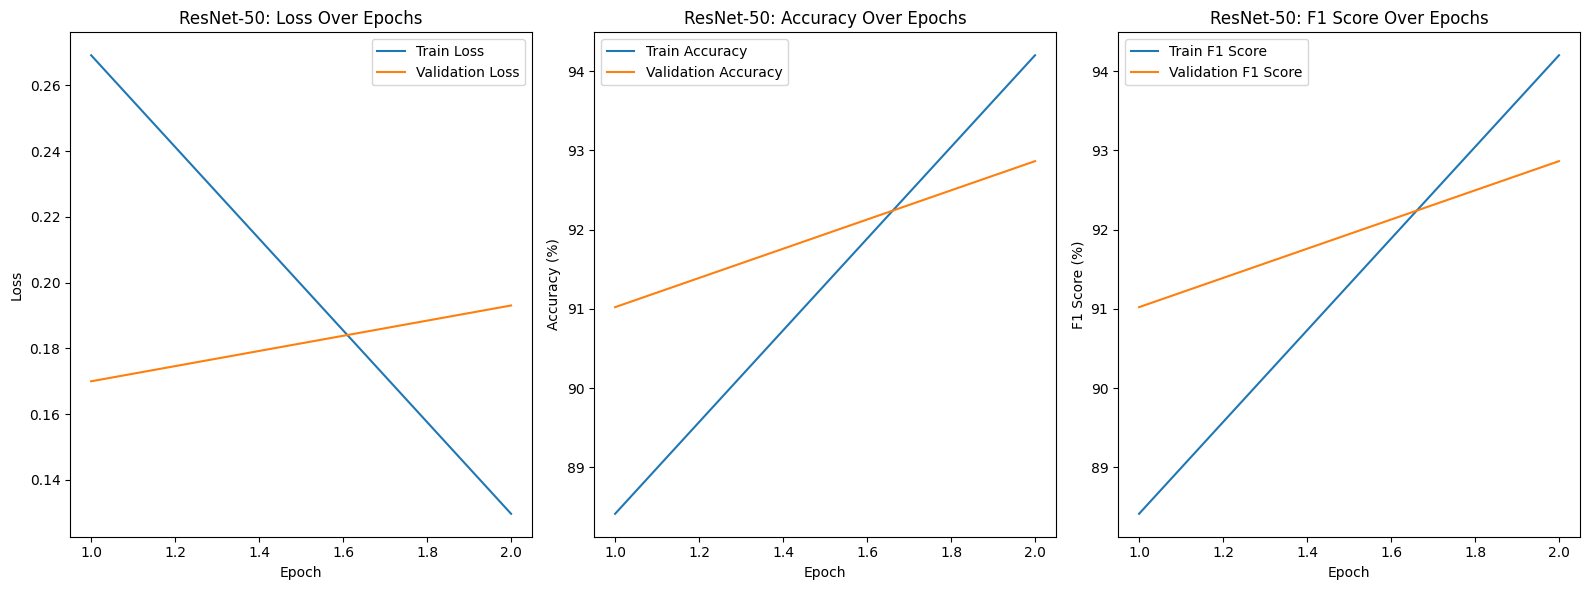

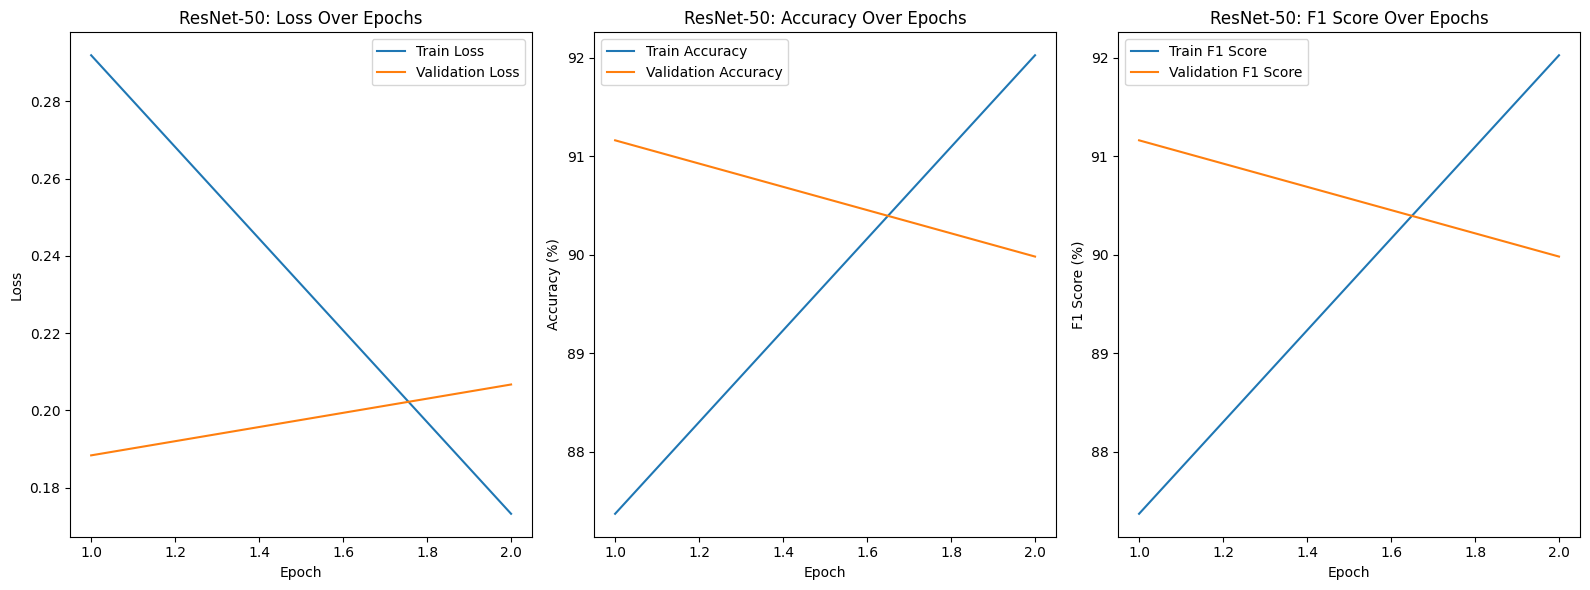

In [31]:
plot_results(
    epochs_range=EPOCH_RANGE,
    model_name=MODEL_NAME_RESNET50,
    train_metrics=resnet50_train_metrics,
    val_metrics=resnet50_val_metrics,
)
plot_results(
    epochs_range=EPOCH_RANGE,
    model_name=MODEL_NAME_RESNET50,
    train_metrics=densenet121_train_metrics,
    val_metrics=densenet121_val_metrics,
)

### Classifications

In [32]:
def make_all_predictions(
    model: nn.Module,
    model_name: str,
    data_loader: DataLoader,
    criterion: nn.Module,
    metrics: list[nn.Module],
    device: torch.device,
) -> tuple[torch.Tensor, torch.Tensor]:
    """
    Make predictions over an entire dataset and calculates metrics.

    Args:
        model: Trained model to use for predictions.
        model_name: Model name for printing outputs.
        data_loader: DataLoader for dataset to predict on.
        criterion: Loss function to compute loss.
        metrics: Metric modules to compute during prediction.
        device: Device for computation.

    Returns:
        A tuple containing concatenated predicted labels and true labels.
    """
    model_file_name = model.__class__.__name__.lower()
    model.load_state_dict(
        state_dict=torch.load(f=f"{model_file_name}_best.pth", map_location=device)
    )
    model.to(device)
    model.eval()
    all_preds = []
    all_labels = []
    test_loss = 0.0
    n_total_samples = len(data_loader.dataset)
    for metric in metrics:
        metric.reset()

    with torch.inference_mode():
        for inputs, labels in data_loader:
            batch_size = inputs.size(0)
            inputs, labels = inputs.to(device), labels.to(device)

            # 1. Forward pass
            y_logits = model(inputs)
            y_probs = torch.softmax(y_logits, dim=1)
            y_preds = torch.argmax(y_probs, dim=1)

            all_preds.append(y_preds.cpu())
            all_labels.append(labels.cpu())

            # 2. Calculate test loss
            test_loss += criterion(y_logits, labels).item() * batch_size

            # 3. Calculate test metrics
            for metric in metrics:
                metric.update(y_preds, labels)

    test_loss /= n_total_samples
    test_acc = metrics[0].compute().item() * 100
    test_f1 = metrics[1].compute().item() * 100
    print(f"{model_name}\n{'=' * 60}")
    print(
        f"{'Test Loss':<12}{test_loss:>6.4f} | {'Test Accuracy':<15}{test_acc:>6.2f}% | {'Test F1:':<10}{test_f1:>6.2f}%\n"
    )
    all_preds_tensor = torch.cat(all_preds)
    all_labels_tensor = torch.cat(all_labels)
    return all_preds_tensor, all_labels_tensor

Creating a new model instance before loading saved weights ensures the model to start from a clean, well-defined architecture without any unintended changes or leftover states from previous training runs (such as optimiser internal states, hooks, or temporarily stored variables). This practice helps avoid bugs and inconsistencies during evaluation.

Subsequently, the `make_all_predictions()` function uses this freshly loaded, optimised model (with trained weights) to generate predictions reliably for the dataset, ensuring that the evaluation reflects the learned parameters from training.

In [33]:
resnet50 = ResNet50(num_classes=N_CLASSES, is_frozen=False, device=DEVICE)

all_preds_resnet50, all_labels_resnet50 = make_all_predictions(
    model=resnet50,
    model_name=MODEL_NAME_RESNET50,
    data_loader=test_loader,
    criterion=criterion,
    metrics=metrics,
    device=DEVICE,
)

densenet121 = DenseNet121(num_classes=N_CLASSES, is_frozen=False, device=DEVICE)

all_preds_densenet121, all_labels_densenet121 = make_all_predictions(
    model=densenet121,
    model_name=MODEL_NAME_DENSENET121,
    data_loader=test_loader,
    criterion=criterion,
    metrics=metrics,
    device=DEVICE,
)

ResNet-50
Test Loss   0.1733 | Test Accuracy   92.49% | Test F1:   92.49%

DenseNet-121
Test Loss   0.1635 | Test Accuracy   92.82% | Test F1:   92.82%



In [34]:
print(f"{MODEL_NAME_RESNET50}\n{'=' * 60}")
print(classification_report(y_true=all_labels_resnet50, y_pred=all_preds_resnet50))
print(
    classification_report(y_true=all_labels_densenet121, y_pred=all_preds_densenet121)
)

ResNet-50
              precision    recall  f1-score   support

           0       0.91      0.99      0.95       362
           1       0.89      0.92      0.90       602
           2       0.96      0.90      0.93      1019
           3       0.92      0.96      0.94       134

    accuracy                           0.92      2117
   macro avg       0.92      0.94      0.93      2117
weighted avg       0.93      0.92      0.92      2117

              precision    recall  f1-score   support

           0       0.90      0.98      0.94       362
           1       0.91      0.91      0.91       602
           2       0.95      0.92      0.93      1019
           3       0.94      0.96      0.95       134

    accuracy                           0.93      2117
   macro avg       0.92      0.94      0.93      2117
weighted avg       0.93      0.93      0.93      2117



### Missclassifications

In [35]:
def print_missclassifications(
    all_preds: torch.Tensor,
    all_labels: torch.Tensor,
    model_name: str,
) -> None:
    missclassified = all_preds != all_labels
    n_missclassified = int(missclassified.sum())
    missclassified_rate = 100 * n_missclassified / len(all_labels)
    print(f"{model_name}\n{'=' * 60}")
    print(
        f"Number of failed predictions: {n_missclassified}/{len(all_labels)} ({missclassified_rate:.2f}%)\n"
    )

In [36]:
print_missclassifications(
    all_preds=all_preds_resnet50,
    all_labels=all_labels_resnet50,
    model_name=MODEL_NAME_RESNET50,
)
print_missclassifications(
    all_preds=all_preds_densenet121,
    all_labels=all_labels_densenet121,
    model_name=MODEL_NAME_DENSENET121,
)

ResNet-50
Number of failed predictions: 159/2117 (7.51%)

DenseNet-121
Number of failed predictions: 152/2117 (7.18%)



### Confusion Matrix

In [37]:
def plot_confusion_matirx(
    cm: NDArray[np.int64] | torch.Tensor,
    class_names: list[str],
    model_name: str,
) -> None:
    """
    Plot a confusion matrix using seaborn heatmap.

    Args:
        cm: Confusion matrix data.
        class_names: List of class names for axes.
        model_name: Model name for plot title.
    """
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        data=cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names,
    )
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(f"{model_name}: Confusion Matrix")
    plt.show()

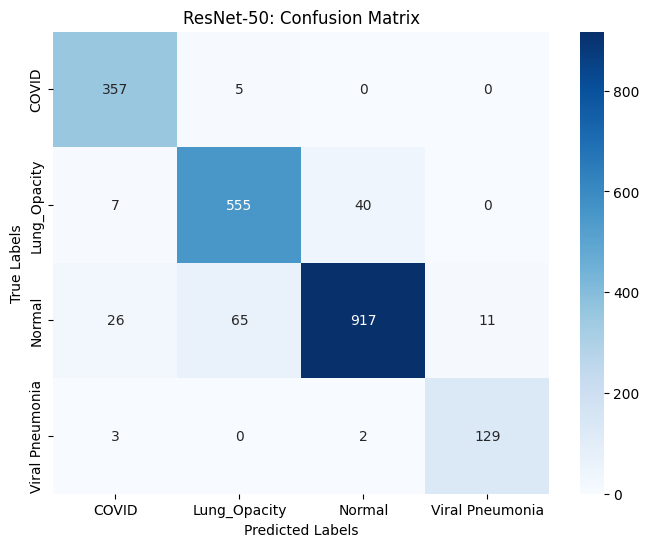

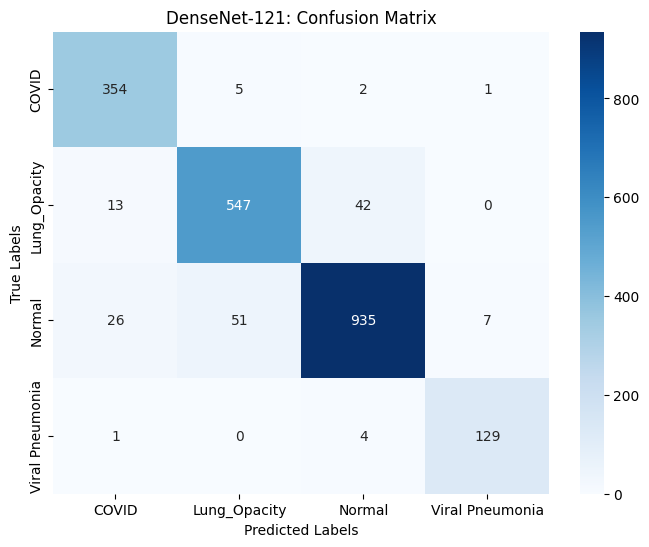

In [38]:
cm_resnet50 = confusion_matrix(y_true=all_labels_resnet50, y_pred=all_preds_resnet50)

cm_densenet121 = confusion_matrix(
    y_true=all_labels_densenet121, y_pred=all_preds_densenet121
)

plot_confusion_matirx(
    cm=cm_resnet50,
    class_names=CLASS_NAMES,
    model_name=MODEL_NAME_RESNET50,
)

plot_confusion_matirx(
    cm=cm_densenet121,
    class_names=CLASS_NAMES,
    model_name=MODEL_NAME_DENSENET121,
)


### Observations

## 12. Vision Transformer (ViT)
The Vision Transformer (ViT) is a model architecture adapted from transformer models originally developed for natural language processing (NLP), specifically tailored for computer vision tasks. ViT treats an image as a sequence of fixed-size patches, analogous to tokens in text processing. These image patches are linearly embedded and then processed through transformer encoder layers, which utilise self-attention mechanisms to capture relationships between different parts of the image.

The advantages of transformers, including global context understanding, parallelisability, and high performance with large datasets, have made the Vision Transformer particularly successful not only in text processing but also in computer vision.
### Converting Image Data for ViT
The Hugging Face `Trainer` excepts datasets to return dictionaries rather than tuples. For image classification, it needs to be:
```
{
    'pixel_values': tensor_of_image,
    'labels: label_integer
}
```

In [39]:
warnings.filterwarnings(
    "ignore", message="'pin_memory' argument is set as true but not supported on MPS"
)

In [40]:
class TransformerDatasetWrapper(Dataset):
    """
    Wrapper around a dataset to output inputs as dictionary with 'pixel_values' and 'labels',
    compatible with Hugging Face Trainer.

    Attributes:
        dataset: Original dataset.
    """

    def __init__(self, dataset: Dataset) -> None:
        """
        Initialise with original dataset.

        Args:
            dataset: The dataset to wrap.
        """
        self.dataset = dataset

    def __len__(self) -> int:
        """
        Return the number of samples.

        Returns:
            int: Dataset length.
        """
        return len(self.dataset)

    def __getitem__(self, index: int) -> dict[str, torch.Tensor]:
        """
        Return a sample as a dictionary with keys 'pixel_values' and 'labels'.

        Args:
            index: Sample index.

        Returns:
            Sample dictionary.
        """
        image, label = self.dataset[index]
        return {
            "pixel_values": image,
            "labels": label,
        }

In [41]:
train_dataset_vit = TransformerDatasetWrapper(dataset=train_dataset)
val_dataset_vit = TransformerDatasetWrapper(dataset=val_dataset)
test_dataset_vit = TransformerDatasetWrapper(dataset=test_dataset)

In [42]:
MY_MODEL_PATH = "./my_finetuned_model"
N_EPOCHS_VIT = 1
LABEL_2_ID = dataset.label2id
ID_2_LABEL = dataset.id2label

### Loading Pre-Trained Model

In [43]:
from transformers import ViTForImageClassification, ViTImageProcessor

VIT_MODEL_NAME = "google/vit-base-patch16-224-in21k"
VIT_MODEL = ViTForImageClassification.from_pretrained(
    pretrained_model_name_or_path=VIT_MODEL_NAME,
    id2label=ID_2_LABEL,
    label2id=LABEL_2_ID,
)
VIT_PROCESSOR = ViTImageProcessor.from_pretrained(
    pretrained_model_name_or_path=VIT_MODEL_NAME
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Training Arguments
The following code configures the training arguments for fine-tuning a Transformer model using Hugger Face's `Trainer` API.

In [44]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    report_to="none",
    eval_strategy="epoch",
    learning_rate=2e-5,
    logging_steps=100,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=N_EPOCHS_VIT,
    weight_decay=0.01,
    seed=RANDOM_SEED,
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
)

### Evaluation Metrics for ViT
The overall performance of the fine‑tuned model will be evaluated using two metrics: accuracy and the F1‑score.

In [45]:
import evaluate

accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")


def compute_metrics(
    eval_pred: tuple[NDArray[np.float32], NDArray[np.int64]],
) -> dict[str, float]:
    """
    Compute accuracy and weighted F1 score metrics suitable for Hugging Face Trainer evaluation.

    Args:
        eval_pred: Tuple with model logits and true labels.

    Returns:
        Dictionary with "accuracy" and "f1" metric scores.
    """
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    acc = accuracy_metric.compute(predictions=predictions, references=labels)
    f1 = f1_metric.compute(
        predictions=predictions, references=labels, average="weighted"
    )
    return {"accuracy": acc["accuracy"], "f1": f1["f1"]}

### Fine-Tuning Transformer Model

In [46]:
from transformers import Trainer

trainer = Trainer(
    model=VIT_MODEL,
    args=training_args,
    train_dataset=train_dataset_vit,
    eval_dataset=val_dataset_vit,
    compute_metrics=compute_metrics,
    processing_class=VIT_PROCESSOR,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.208400,0.222975,0.938563,0.938539


TrainOutput(global_step=1059, training_loss=0.3730908079570594, metrics={'train_runtime': 1478.2727, 'train_samples_per_second': 11.454, 'train_steps_per_second': 0.716, 'total_flos': 1.3121178879278776e+18, 'train_loss': 0.3730908079570594, 'epoch': 1.0})

### Predictions with Fine-Tuned Model

In [ ]:
eval_results_on_test = trainer.evaluate(eval_dataset=test_dataset_vit)
print(eval_results_on_test)

{'eval_loss': 0.21601411700248718, 'eval_accuracy': 0.9390647142182333, 'eval_f1': 0.9390052578373747, 'eval_runtime': 58.4518, 'eval_samples_per_second': 36.218, 'eval_steps_per_second': 2.275, 'epoch': 1.0}
